In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
from matplotlib import pyplot as plt
sys.path.append("../../")
from spook import SpookPosL1

Text(0.5, 0, 'Delay bin')

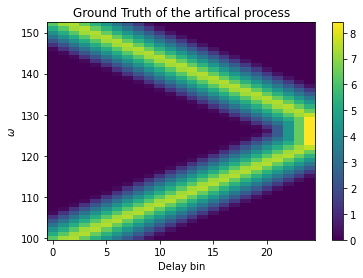

In [3]:
Nw = 53
Nt = 25
taxis, waxis = np.arange(Nt), np.arange(Nw)+100

Xtrue = np.zeros((Nw, Nt))
bb, aa = np.meshgrid(taxis, waxis)
for p1, p2 in zip([1,-1],[1,-1]):
    tmp = 0.1*(Nw+Nt) - abs((aa - waxis[Nw//2]) + p1* (bb - Nt//2) - p2* 0.2*(Nw+Nt))
    tmp[tmp<0] = 0
    Xtrue += tmp

plt.pcolormesh(taxis, waxis, Xtrue, shading="nearest")
plt.colorbar()
plt.title("Ground Truth of the artifical process")
plt.ylabel("$\omega$")
plt.xlabel("Delay bin")

In [4]:
def axis2bin(axis):
    b = 0.5*(axis[1:]+axis[:-1])
    d0 = b[0]-axis[0]
    b = np.insert(b, 0, axis[0]-d0)
    d_1 = b[-1]-axis[-1]
    b = np.append(b, axis[-1]-d_1)
    return b

tbins = axis2bin(taxis)

In [33]:
Ns = 10000
np.random.seed(2022)
raw_spec_data = []
for i in range(Ns):
    # random artificial photon spectrum
    ai = np.random.rand(Nw) * 5 
    # random delay
    di = np.random.rand()*tbins.ptp() + tbins.min()
    jdelaybin = np.digitize(di, tbins)-1
    # yield
    yi = ai @ Xtrue[:,jdelaybin] + np.random.randn()*0.5
    raw_spec_data.append((ai, di, yi))

Now that `raw_spec_data` is a list of singleshot's `(photon_spectra, delay, yield)`, how to extract the underlying process?

## Directly sparsely embedding into $B$ 
leads to poor results

In [34]:
A = []
B = []
for ai, di, yi in raw_spec_data:
    A.append(ai)
    jdelaybin = np.digitize(di, tbins)-1
    # There is a -1 because numpy.digitize returns 0 for values lower than the
    # 0-th entry in bins. 
    b = np.zeros((taxis.size,))
    b[jdelaybin] = yi
    B.append(b)
A, B = np.asarray(A), np.asarray(B)

In [35]:
SpookPosL1.verbose=True
spk0 = SpookPosL1(B, A, "raw", lsparse=0.1, lsmooth=(0.,0.0))

Setting up the OSQP problem


Text(0.5, 0, 'Delay bin')

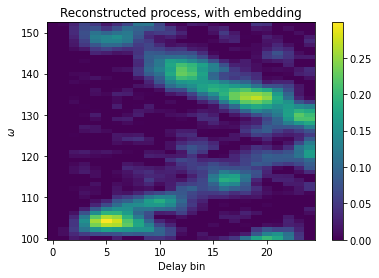

In [41]:
X0 = spk0.getXopt(lsparse=1e3, lsmooth=(1,1))
plt.pcolormesh(taxis, waxis, X0, shading="nearest")
plt.colorbar()
plt.title("Reconstructed process, with embedding")
plt.ylabel("$\omega$")
plt.xlabel("Delay bin")

### Why does directly embedding not work?
The objective in this way is 
$$f(X) = \sum_i \|a_i^TX-b_i^T\|^2 = \sum_{i,t} (a_i^TX_{:,t}-b_{i,t})^2$$
where $a_i^T\in \mathbb{R}_{1\times N_w}$ is the photon spectrum of shot $i$, $b_i^T\in \mathbb{R}_{1\times N_t}$ is the yield vector whose only non-zero entry is at the delay bin where shot $i$ falls in.

For each shot $i$, this objective penalizes the discrepancy on irrelavant delay bins as well as the delay bin that shot $i$ is in. This is the reason.

## Projective Encoding
The objective should be the L2 of the discrepancy at the relevant delay bin only
$$f(X) = \sum_i ((a_i^TX-b_i^T)e_{t_i})^2$$
where $e_{t_i}$ is the unit vector whose only unity entry is at the delay bin $t_i$ that shot $i$ falls in.
$$f(X) = \sum_i e_{t_i}^TX^Ta_ia_i^TXe_{t_i} - 2\sum_ie_{t_i}^Tb_ia_i^TXe_{t_i} +C$$

In [37]:
A = []
B = []
for ai, di, yi in raw_spec_data:
    A.append(ai)
    jdelaybin = np.digitize(di, tbins)-1
    # There is a -1 because numpy.digitize returns 0 for values lower than the
    # 0-th entry in bins. 
    B.append((jdelaybin, yi))
A = np.asarray(A)

In [38]:
spk1 = SpookPosL1(B, A, "projective", lsparse=0.0, lsmooth=(0.,0.0))

Setting up the OSQP problem


Text(0.5, 0, 'Delay bin')

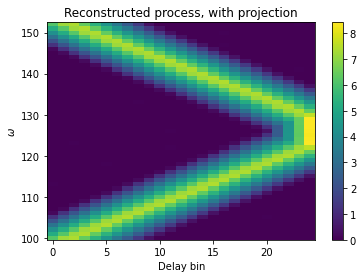

In [42]:
X1 = spk1.getXopt()
plt.pcolormesh(taxis, waxis, X1, shading="nearest")
plt.colorbar()
plt.title("Reconstructed process, with projection")
plt.ylabel("$\omega$")
plt.xlabel("Delay bin")

Text(0.5, 0, 'Delay bin')

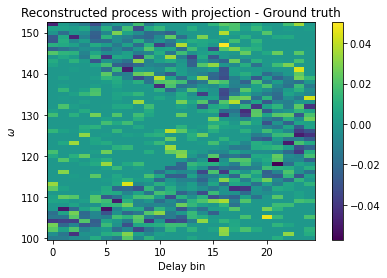

In [43]:
plt.pcolormesh(taxis, waxis, X1-Xtrue, shading="nearest")
plt.colorbar()
plt.title("Reconstructed process with projection - Ground truth")
plt.ylabel("$\omega$")
plt.xlabel("Delay bin")